In [1]:
import random
from pathlib import Path
import time
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
#import wandb
import torchvision.transforms.functional as TF
from decoder_pretrain import DecoderPretrainNet
from encoder_pretrain import EncoderPretrainNet
from loccont_loss import LocalContrastiveLoss
from gloss_d import GlobalLossD
from gloss_dminus import GlobalLossDminus
from seg_unet import UNet
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import statistics

import argparse
import pdb
import json



import random
from skimage import transform
from collections import OrderedDict
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
with open('configs/preprocessing_datasets.json') as config_file:
    config_datasets = json.load(config_file)
with open('configs/config_encoder.json') as config_file:
    config_encoder = json.load(config_file)

# init W&B
#print("Using W&B in %s mode" % 'online')
#wandb.init(project=config_encoder["model"], mode='online')
torch.manual_seed(config_encoder['seed'])
np.random.seed(config_encoder['seed'])

In [3]:
# choose model from config
model = {
    "encoder_pretrain": lambda: EncoderPretrainNet(config_encoder),
    #"decoder_pretrain": lambda: DecoderPretrainNet(config_encoder),
    #"seg_unet": lambda: UNet(config_enoder),
}[config_encoder['model']]()

# choose specified optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config_encoder["lr"])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
model.to(device)
print("Running model %s" % config_encoder["model"])

with open('configs/preprocessing_datasets.json') as config_file:
    config_datasets = json.load(config_file)
with open('configs/config_encoder.json') as config_file:
    config_encoder = json.load(config_file)

# init W&B
#print("Using W&B in %s mode" % 'online')
#wandb.init(project=config_encoder["model"], mode='online')
#wandb.config = config_encoder

torch.manual_seed(config_encoder['seed'])
np.random.seed(config_encoder['seed'])

Using device:  cpu
Running model encoder_pretrain


In [4]:
#def transform(self, volume) : #, mask) :
class custom_transforms(object):

    def __init__(self, output_size) :
        assert isinstance(output_size, (int,tuple))
        self.output_size = output_size
        
    def __call__(self, image, dtype ='train'):
        
        img = image 
        
        if dtype != 'train' :
            random.seed(103)
        resize = transforms.Resize(size = (224,224))
        i,j,h,w = transforms.RandomCrop.get_params(image, output_size= (224,224))
        rand_hor = random.random()
        rand_vert = random.random()
        
        
        brightness_factor = random.uniform(0, 0.3)
        contrast_factor = random.uniform(0.7, 1.3)
        
        #Random crop
        #image = TF.crop(image,i,j,h,w)
        #mask = TF = crop(mask,i,j,h,w)

        #Random flipping
        #if rand_hor > 0.5 :
        #    image = TF.hflip(image)
            #mask = TP.hflip(mask)

        #Random vertical flipping 
        #if rand_vert > 0.5:
        #    image = TF.vflip(image)
            #mask = TF.vflip(mask)
        
        return_image = image * contrast_factor + brightness_factor        
        return_image = torch.clip(return_image, 0, 1.5) 
        
        #volume[:,:,idx_image] = image
        #fig, axs = plt.subplots(1, 2)
        #axs[0].imshow(img[0,0,:,:])
        #axs[1].imshow(return_image[0,0,:,:])
    
        return return_image# volume #, mask
    
    def __repr__(self):
        return self.__class__.__name__+'()'


In [5]:
def plotPCA(pred, norm) :
    n_components=2
    
    if norm:
        X = pd.DataFrame(preprocessing.normalize(np.asarray(pred['prediction'].tolist())), index = pred['type'])
    else :
        X = pd.DataFrame(np.asarray(pred['prediction'].tolist()), index = pred['type'])
    
    pca = PCA(n_components)
    components = pca.fit_transform(X)
    #labels = {str(i): f"PC {i+1}" for i in range(n_components)}
    #labels['color'] = 'Dataset type'

    if norm :
        name = 'Norm PCA Component '+str(1) +' VS ' + str(2)
    else :
        name = 'PCA Component '+str(1) +' VS ' + str(2)
    fig = px.scatter(components, x=0, y=1, color=X.index, title=name,width=600, height=400, opacity = 0.7)
    fig.show()
    return fig

In [6]:
def plotTSNE(pred, norm, num_datasets, perplexity) :
    n_components=2
    
    if norm:
        X = pd.DataFrame(preprocessing.normalize(np.asarray(pred['prediction'].tolist())), index = pred['type'])
    else :
        X = pd.DataFrame(np.asarray(pred['prediction'].tolist()), index = pred['type'])
    
    tsne = TSNE(random_state=12, n_components=n_components, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X)
    
    fig = px.scatter(tsne_results, x=0, y=1, color=X.index,title='tSNE', width=600, height=400, opacity = 0.7)
    fig.show()

    return fig

In [7]:
class TrainDatasetSmallExp(torch.utils.data.Dataset):
    def __init__(self, cfg_dataset, cfg_encoder, datasets, n_partitions, set):
        self.filenames = datasets
        

        #for dataset in self.filenames :
            #print(dataset)
            
        self.n_vols = len(self.filenames[0])
        
        self.n_partitions = n_partitions#cfg_encoder["n_parts"]
        self.name = cfg_dataset["Data"]
        self.n_parts = cfg_dataset["n_parts"]
        self.batch_size = cfg_encoder["batch_size"]
    
    def sample_minibatch_for_global_loss(self,dataset, idx, n_parts): 
        #print(idx)
        vol_file = self.filenames[dataset][idx]
        volume = nib.load(vol_file).get_fdata()

        n_slices = volume.shape[2]
        # starting index of first partition of any chosen volume
        self.partition_lengths = [0]
        # find the starting and last index of each partition in a volume based on input image size. 
        # shape[0] indicates total no. of slices in axial direction of the input image.
        for k in range(1, n_parts + 1):
            self.partition_lengths.append(k * int(n_slices / n_parts))
        # Now sample 1 image from each partition randomly. Overall, n_parts images for each chosen volume id.
        idces = []
        for k in range(0, len(self.partition_lengths) - 1):
            # sample image from each partition randomly
            i_sel = random.sample(range(self.partition_lengths[k], self.partition_lengths[k + 1]), 1)
            # print('k,i_sel',k+count, i_sel)
            idces.append(i_sel[0])
        #fig, axs = plt.subplots(1, 2)
        #axs[0].imshow(volume[:, :, 0])
        #axs[1].imshow(volume[:, :, 1])
        #plt.show()
        return volume[:, :, idces].transpose(2, 0, 1)

    def __len__(self):
        return max(len(self.filenames[0]),len(self.filenames[1]))

    def __getitem__(self, idx):
        for dataset in range(len(self.filenames)) :
            
            if idx >= len(self.filenames[dataset]):
                    lower_idx = random.randrange(len(self.filenames[dataset]))
            else : lower_idx = idx
            
            new_slices = self.sample_minibatch_for_global_loss(dataset, lower_idx, self.n_partitions[dataset])
           
            if dataset == 0 :
                slices = new_slices                
            else :
                slices = np.concatenate((slices, new_slices), axis=0)
                
        return slices


In [8]:
class TestDatasetSmallExp(torch.utils.data.Dataset):
    def __init__(self, cfg_dataset, cfg_encoder, datasets, set):
        self.filenames = datasets
        

        #for dataset in self.filenames :
            #print(dataset)
            
        #self.n_vols = len(self.filenames[0]) + len(self.filenames[1])
        
        self.n_parts = cfg_encoder["n_parts"]
        self.name = cfg_dataset["Data"]
        self.n_parts = cfg_dataset["n_parts"]
        self.batch_size = cfg_encoder["batch_size"]
    
    def sample_minibatch_for_global_loss(self, idx, n_parts): 
        #print(idx)
        vol_file = self.filenames[idx]
        
        volume = nib.load(vol_file).get_fdata()

        n_slices = volume.shape[2]
        # starting index of first partition of any chosen volume
        self.partition_lengths = [0]
        # find the starting and last index of each partition in a volume based on input image size. 
        # shape[0] indicates total no. of slices in axial direction of the input image.
        for k in range(1, n_parts + 1):
            self.partition_lengths.append(k * int(n_slices / n_parts))
        # Now sample 1 image from each partition randomly. Overall, n_parts images for each chosen volume id.
        idces = []
        for k in range(0, len(self.partition_lengths) - 1):
            # sample image from each partition randomly
            i_sel = random.sample(range(self.partition_lengths[k], self.partition_lengths[k + 1]), 1)
            # print('k,i_sel',k+count, i_sel)
            idces.append(i_sel[0])
        #fig, axs = plt.subplots(1, 2)
        #axs[0].imshow(volume[:, :, 0])
        #axs[1].imshow(volume[:, :, 1])
        #plt.show()
        return volume[:, :, idces].transpose(2, 0, 1)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        #for dataset in range(len(self.filenames)) :
        #    
        #    if idx >= len(self.filenames[dataset]):
        #            lower_idx = random.randrange(len(self.filenames[dataset]))
        #    else : lower_idx = idx
        for dataset in range(len(self.filenames)) :
            if idx >= len(self.filenames[dataset]):
                    lower_idx = random.randrange(len(self.filenames[dataset]))
            else : lower_idx = idx
            if dataset == 0 :
                n_parts = 4
                new_slices = self.sample_minibatch_for_global_loss(dataset, lower_idx, n_parts)
            if dataset == 1 :
                n_parts = 6
                new_slices = self.sample_minibatch_for_global_loss(dataset, lower_idx, n_parts)
            if dataset == 2 :
                n_parts = 10
                new_slices = self.sample_minibatch_for_global_loss(dataset, lower_idx, n_parts)
            if dataset == 0 :
                slices = new_slices                
            else :
                slices = np.concatenate((slices, new_slices), axis=0)
                
        new_slices = self.sample_minibatch_for_global_loss(idx)

        
        return new_slices


In [9]:
trans = custom_transforms((224,224))

In [10]:
# choose model from config
model = {
    "encoder_pretrain": lambda: EncoderPretrainNet(config_encoder),
    #"decoder_pretrain": lambda: DecoderPretrainNet(config_encoder),
    #"seg_unet": lambda: UNet(config_enoder),
}[config_encoder['model']]()

# choose specified optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config_encoder["lr"])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
model.to(device)
print("Running model %s" % config_encoder["model"])

Using device:  cpu
Running model encoder_pretrain


### Full Datasets

In [20]:
datasets_train = []
datasets_validation = []
datasets_test = []

volumes_train_heart = []
volumes_validation_heart = []
volumes_test_heart = []

volumes_train_prostate = []
volumes_validation_prostate = []
volumes_test_prostate = []

volumes_train_brain = []
volumes_validation_brain = []
volumes_test_brain = []

datasets = []
n_partitions = []
for config_dataset in config_datasets:
    if config_dataset['Data'] == 'ACDC' or config_dataset['Data'] == 'Medical Decathelon Prostate' or config_dataset['Data'] == 'Medical Decathelon Brain 1':
        if  config_dataset['class'] == 'Heart' :
            for path in Path( config_dataset["savedir"]).rglob( "train/*/img_cropped.nii.gz"):
                volumes_train_heart.append(path)
            for path in Path( config_dataset["savedir"]).rglob( "validation/*/img_cropped.nii.gz"):
                volumes_validation_heart.append(path)
            for path in Path( config_dataset["savedir"]).rglob( "test/*/img_cropped.nii.gz"):
                volumes_test_heart.append(path)
                #datasets_test.append(path)
        if  config_dataset['class'] == 'Prostate':

            for path in Path( config_dataset["savedir"]).rglob( "train/*/img_cropped.nii.gz"):
                volumes_train_prostate.append(path)
            for path in Path( config_dataset["savedir"]).rglob( "validation/*/img_cropped.nii.gz"):
                volumes_validation_prostate.append(path)
            for path in Path( config_dataset["savedir"]).rglob( "test/*/img_cropped.nii.gz"):
                volumes_test_prostate.append(path)
                #datasets_test.append(path)
        
        if  config_dataset['class'] == 'Brain':

            for path in Path( config_dataset["savedir"]).rglob( "train/*/img_cropped.nii.gz"):
                volumes_train_brain.append(path)
            for path in Path( config_dataset["savedir"]).rglob( "validation/*/img_cropped.nii.gz"):
                volumes_validation_brain.append(path)
            for path in Path( config_dataset["savedir"]).rglob( "test/*/img_cropped.nii.gz"):
                volumes_test_brain.append(path)
                #datasets_test.append(path)
        n_partitions.append(config_dataset["n_parts"])
        datasets.append(config_dataset['Data'])
print(n_partitions)
datasets_train.append(volumes_train_heart)
datasets_train.append(volumes_train_prostate)
datasets_train.append(volumes_train_brain)
datasets_validation.append(volumes_validation_heart)
datasets_validation.append(volumes_validation_prostate)
datasets_validation.append(volumes_validation_brain)
datasets_test.append(volumes_test_heart)
datasets_test.append(volumes_test_prostate)
datasets_test.append(volumes_test_brain)
total_n_parts = 0
for n_parts in n_partitions : 
    total_n_parts += n_parts

dataset_train = TrainDatasetSmallExp(config_dataset, config_encoder, datasets_train, n_partitions, 'train')
dataset_loader_train = DataLoader(dataset_train,
                            num_workers=1,
                            batch_size=config_encoder['batch_size'],
                            pin_memory=True,
                            shuffle=True,
                            drop_last=True)

dataset_validation = TrainDatasetSmallExp(config_dataset, config_encoder, datasets_validation, n_partitions, 'validation')
dataset_loader_validation = DataLoader(dataset_validation,
                            num_workers=1,
                            batch_size=config_encoder['batch_size'],
                            #pin_memory=True,
                            shuffle=False,
                            drop_last=False)

        
dataset_test = TrainDatasetSmallExp(config_dataset, config_encoder, datasets_test, n_partitions, 'test')
dataset_loader_test = DataLoader(dataset_test,
                            num_workers=1,
                            batch_size=config_encoder['test_batch_size'],
                            #pin_memory=True,
                            shuffle=False,
                            drop_last=False)

[4, 5, 10]


### 2 volumes

In [28]:
for config_dataset in config_datasets:
    if config_dataset['Data'] == 'ACDC' :#or config_daraset['Data'] == 'Medical Decathelon Prostate' :

        print("Using configs of dataset : ", config_dataset['Data'])
        #ACDC
        volume_1 = '../img_cropped/small_exp/image_1/img_cropped.nii.gz'
        volume_3 = '../img_cropped/small_exp/image_3/img_cropped.nii.gz'
        #Prostate
        volume_2 = '../img_cropped/small_exp/image_2/img_cropped.nii.gz'
        volume_4 = '../img_cropped/small_exp/image_4/img_cropped.nii.gz'
        #Brain
        volume_5 = '../img_cropped/small_exp/image_5/img_cropped.nii.gz'
        volume_6 = '../img_cropped/small_exp/image_6/img_cropped.nii.gz'
        #volumes = [[volume_1, volume_3],[volume_2, volume_4]]
        volumes = [[volume_1,volume_1], [volume_2,volume_2], [volume_5, volume_5]]
        volumes_validation = [[volume_3, volume_3], [volume_4, volume_4], [volume_6, volume_6]]
        volumes_test = [[volume_1, volume_3], [volume_2, volume_4], [volume_5, volume_6]]
        n_partitions = [3, 5, 10]
        dataset_train = TrainDatasetSmallExp(config_dataset, config_encoder, volumes, n_partitions,'train')
        dataset_loader_train = DataLoader(dataset_train,
                                    num_workers=1,
                                    batch_size=config_encoder['batch_size'],
                                    pin_memory=True,
                                    shuffle=True,
                                    drop_last=True)
        
        dataset_validation = TrainDatasetSmallExp(config_dataset, config_encoder, volumes_validation, n_partitions, 'validation')
        dataset_loader_validation = DataLoader(dataset_validation,
                            num_workers=1,
                            batch_size=config_encoder['batch_size'],
                            #pin_memory=True,
                            shuffle=False,
                            drop_last=False)

        dataset_test = TrainDatasetSmallExp(config_dataset, config_encoder, volumes_test, n_partitions, 'test')
        dataset_loader_test = DataLoader(dataset_test,
                                    num_workers=1,
                                    batch_size=config_encoder['batch_size'],
                                    #pin_memory=True,
                                    shuffle=False,
                                    drop_last=False)
total_n_parts = 0
for n_parts in n_partitions : 
    total_n_parts += n_parts

Using configs of dataset :  ACDC


  0%|          | 0/1 [00:00<?, ?it/s]

['ACDC', 'Medical Decathelon Prostate', 'Medical Decathelon Brain 1']


  0%|          | 0/1 [00:02<?, ?it/s]


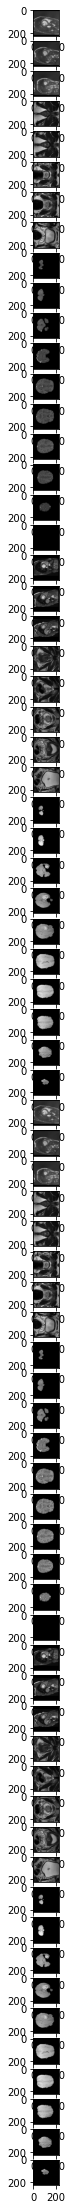

In [29]:
steps = 0
print(datasets)
for batch_x in tqdm(dataset_loader_test):
    
    resize_size = next(item for item in config_datasets if item["Data"] == 'ACDC')['resize_size']
    n_channels = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_channels']
    n_parts = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_parts']
    train_batch = batch_x.float().to(device)
    train_batch = train_batch.view((-1, n_channels, *resize_size))
    train_batch = torch.cat([train_batch, trans(train_batch)])
    fig, axs = plt.subplots(train_batch.shape[0],figsize=(40, 40))
    for i,img in enumerate(train_batch) :
        if (i) % 1 == 0:
            axs[int(i)].imshow(img[0,:,:], cmap = 'gray') 
    break
    
#plt.show()

## Training

In [30]:
import numpy as np
import torch
import torch.nn as nn
import pdb


class GlobalLossDminus(nn.Module):
    def __init__(self, n_partitions, config_encoder, dtype):
        super(GlobalLossDminus, self).__init__()
        if dtype == 'train' :
            self.batch_size = config_encoder['batch_size']
        else :
            self.batch_size = config_encoder['validation_batch_size']
        self.n_partitions = n_partitions
        self.total_n_parts = 0
        for n_parts in self.n_partitions : 
            self.total_n_parts += n_parts
        self.n_datasets = 3
        self.temp_fac = config_encoder['temp_fac']
        self.cos_sim = nn.CosineSimilarity(dim=1, eps=1e-6)
        
    def compute_symmetrical_loss(self, xi, xj, x_den):
        loss_tmp = 0

        num_i1_i2_ss = self.cos_sim(xi, xj) / self.temp_fac
        den_i1_i2_ss = self.cos_sim(xi, x_den) / self.temp_fac
        #print('num : ', num_i1_i2_ss)
        #print('den : ', den_i1_i2_ss)
        num_i1_i2_loss = -torch.log(
            torch.exp(num_i1_i2_ss) / (torch.exp(num_i1_i2_ss) + torch.sum(torch.exp(den_i1_i2_ss))))
        loss_tmp = loss_tmp + num_i1_i2_loss
        # for positive pair (x_2,x_1);
        # numerator same & denominator of loss term (den_i1_i2_ss) & loss (num_i1_i2_loss)
        den_i2_i1_ss = self.cos_sim(xj, x_den) / self.temp_fac
        num_i2_i1_loss = -torch.log(
            torch.exp(num_i1_i2_ss) / (torch.exp(num_i1_i2_ss) + torch.sum(torch.exp(den_i2_i1_ss))))
        
        loss_tmp = loss_tmp + num_i2_i1_loss
        #print('loss : ', num_i1_i2_ss, den_i1_i2_ss, num_i1_i2_loss )
        
        return loss_tmp

    def forward(self, reg_pred):
        #bs = 2 * self.batch_size
    
        net_global_loss = torch.zeros(1, device=reg_pred.device)
        #print('net_global_loss : ', net_global_loss.shape)
        #print('forward loop')
        #print('reg_pred : ', reg_pred.shape)
        #print('batch_size : ', self.batch_size)
        
        for pos_index in range(0, int(reg_pred.shape[0]/2), 1):
            # indexes of positive pair of samples (x_1,x_2,x_3) - we can make 3 pairs: (x_1,x_2), (x_1,x_3), (x_2,x_3)
            
            num_i1 = np.arange(pos_index, pos_index + 1, dtype=np.int32)
            
            j = int(reg_pred.shape[0]/2) + pos_index
            
            num_i2 = np.arange(j, j + 1, dtype=np.int32)
            
            #j = 2 * self.batch_size + pos_index
            #num_i3 = np.arange(j, j + 1, dtype=np.int32)

            # indexes of corresponding negative samples as per positive pair of samples: (x_1,x_2), (x_1,x_3), (x_2,x_3)
            den_index_net = np.arange(0, int(reg_pred.shape[0]), dtype=np.int32)
            #print('den_index_net : ', den_index_net )
            # Pruning the negative samples
            # Deleting the indexes of the samples in the batch used as negative samples for a given positive image. 
            # These indexes belong to identical partitions in other volumes in the batch.
            # Example: if positive image is from partition 1 of volume 1, then NO negative sample are taken 
            # from partition 1 of any other volume (including volume 1) in the batch
            ind_l = []

            # r of euclidian division times the q to get the starting point
            rem = (int(num_i1) % self.total_n_parts) * (int(num_i1) // self.total_n_parts)
            
            # remove for similar dataset the same partition
            for not_neg_index in range(rem, int(reg_pred.shape[0]), self.total_n_parts):
                ind_l.append(not_neg_index)
            
            den_indexes = np.delete(den_index_net, ind_l)

            
            # gather required positive samples x_1,x_2,x_3 for the numerator term
            x_num_i1 = reg_pred[num_i1]
            x_num_i2 = reg_pred[num_i2]
            #x_num_i3 = reg_pred[num_i3]
            
            # gather required negative samples x_1,x_2,x_3 for the denominator term
            x_den = reg_pred[den_indexes]
            #print('x_den : ', x_den.shape)
            # calculate cosine similarity score + global contrastive loss for each pair of positive images
            
            # for positive pair (x_1,x_2) and for positive pair (x_2,x_1)
            #print('pass to compute loss : ', x_num_i1.shape, x_num_i2.shape, x_den.shape)
            net_global_loss += self.compute_symmetrical_loss(x_num_i1, x_num_i2, x_den)
            
            #print('pos_index : ', pos_index)
            #print('j : ', j)
            #print('num_i1 : ', num_i1)
            #print('num_i2 : ', num_i2)
            #print('rem : ', rem)
            #print('ind_l',ind_l)
            #print('den_indexes',den_indexes)
            #print('x_num_i1 shape : ', x_num_i1.shape )
            #print('x_num_i2 shape : ', x_num_i2.shape )
            #print('x_den shape : ', x_den.shape )
            # for positive pair (x_1,x_3) and for positive pair (x_1,x_3)
            #net_global_loss += self.compute_symmetrical_loss(x_num_i1, x_num_i3, x_den)

            # for positive pair (x_2,x_3) and for positive pair (x_3,x_2)
            #net_global_loss += self.compute_symmetrical_loss(x_num_i2, x_num_i3, x_den)
            
        net_global_loss /= (reg_pred.shape[0]/2)
        return net_global_loss.mean()

In [ ]:
steps = 0
steps_val = 0
losses = pd.DataFrame(columns = ['epoch', 'train loss', 'validation loss', 'test loss'])

save_model = "./save_models/" + str(time.strftime("%Y%h%d_%Hh%M"))
Path(save_model).mkdir(parents=True, exist_ok=True)

for epoch in range(50) :
    print("Epoch {:03d}".format(epoch))
    
    # TODO: for seg unet also get batch_y data

    #for loader in train_concatloader:
        #losses = []  
    # do list instead
    model.train()
    batch_train_loss = []
    for batch_x in tqdm(dataset_loader_train):
        
        resize_size = next(item for item in config_datasets if item["Data"] == 'ACDC')['resize_size']
        n_channels = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_channels']
        #n_parts = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_parts']
        print(n_partitions)
        criterion = {"global_dminus": lambda: GlobalLossDminus(n_partitions, config_encoder, 'train'),
                        "global_d": lambda: GlobalLossD(config_encoder),
                        "loccont_loss": lambda: LocalContrastiveLoss(config_encoder),
                        "crossentropy": lambda: nn.CrossEntropyLoss(torch.tensor([0.5, 0.5, 0.5, 0.5]).to(device)),
                     }[config_encoder['loss']]()
        # augment batches by random two separate random transforms

        train_batch = batch_x.float().to(device)
        train_batch = train_batch.view((-1, n_channels, *resize_size))
        train_batch = torch.cat([train_batch, trans(train_batch)])
    
        optimizer.zero_grad(set_to_none=True)
        pred = model(train_batch)
        pred = pred.squeeze()
        
        # this is loss for pretraining
        if isinstance(model, EncoderPretrainNet) or isinstance(model, DecoderPretrainNet):
            loss = criterion(pred)
        else:
            #TODO: for testing using same class (=1), need to get correct mask
            loss = criterion(pred, torch.ones((pred.shape[0], *resize_size), device=device).long())
        batch_train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    train_loss = statistics.mean(batch_train_loss)
    #wandb.log({"train loss": train_loss, 'epoch': steps})
    
    print("Current train loss: %f" % train_loss)  
    
    model.eval()
    batch_val_loss = []
    print("Doing Validation...")
    for batch_x in tqdm(dataset_loader_validation):
        
        resize_size = next(item for item in config_datasets if item["Data"] == 'ACDC')['resize_size']
        n_channels = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_channels']
        #n_parts = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_parts']
        
        criterion = {"global_dminus": lambda: GlobalLossDminus(n_partitions, config_encoder, 'validation'),
                        "global_d": lambda: GlobalLossD(config_encoder),
                        "loccont_loss": lambda: LocalContrastiveLoss(config_encoder),
                        "crossentropy": lambda: nn.CrossEntropyLoss(torch.tensor([0.5, 0.5, 0.5, 0.5]).to(device)),
                     }[config_encoder['loss']]()
        
        batch_val = batch_x.float().to(device)
        batch_val = batch_val.view((-1, n_channels, *resize_size))
        batch_val = torch.cat([batch_val, trans(batch_val, 'validation')])
        
        pred = model(batch_val)
        pred = pred.squeeze()
        if isinstance(model, EncoderPretrainNet) or isinstance(model, DecoderPretrainNet):
            loss_validation = criterion(pred)
        else:
            #TODO: for testing using same class (=1), need to get correct mask
            loss_validation = criterion(pred, torch.ones((pred.shape[0], *resize_size), device=device).long())
        batch_val_loss.append(loss_validation.item())  
    validation_loss = statistics.mean(batch_val_loss)
    #wandb.log({"validation loss": validation_loss, 'epoch': steps})
    print("Current validation loss: %f" % statistics.mean(batch_val_loss))  
    
    losses = losses.append([{'epoch': epoch, 'train loss' : train_loss, 'validation loss' : validation_loss}])
    steps += 1
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            },str(save_model) + "/checkpoints_" + str(epoch)+".pt")
    losses.to_pickle(str(save_model) + "/losses.pkl")
    
    
    
    if (epoch+1) % 1 == 0 :
        
        model.eval()

        predictions = pd.DataFrame(columns = ['type', 'prediction'])
        seed = 123
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        with torch.no_grad():
            print("Doing Test...")
            
            for batch_x in tqdm(dataset_loader_test):
                
                resize_size = next(item for item in config_datasets if item["Data"] == 'ACDC')['resize_size']
                n_channels = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_channels']
                #n_parts = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_parts']
                
                #fig, axs = plt.subplots(batch_test.shape[0],figsize=(60, 60))
                
                batch_test = batch_x.float().to(device)
                batch_test = batch_test.view((-1, n_channels, *resize_size))
                #batch_test = torch.cat([batch_test, trans(batch_test, 'validation')])
                idx = 0
                for batch in batch_test :
                    print('new_image')
                    p = model(batch.unsqueeze(0))
                    p = p.squeeze()  
                    n = 0
                    for i in range(len(n_partitions)) :
                        
                        if i == 0 :
                            if (idx % total_n_parts) < n_partitions[0]:
                                
                                dataset = datasets[0]
                                #print('data ACDC : ', idx,  n_partitions[i],  datasets[i])                        
                        else :
                            print('born inf ', n_partitions[i-1]+n)
                            print('born sup ' ,n_partitions[i]+n)
                            if ((idx % total_n_parts) >= n_partitions[i-1]+n-1) and ((idx % total_n_parts) < n_partitions[i]+n) :
                                dataset = datasets[i]
                                #print(datasets[i])
                        n += n_partitions[i] 
                        
                    print(idx, idx % total_n_parts, dataset)
                    predictions = predictions.append([{'type': dataset, 'prediction' : p.numpy().tolist()}])
                    idx += 1
                    #axs[int(idx)].imshow(batch[0,:,:], cmap = 'gray' )
                    #fig.suptitle(trans_set + dataset + partition)
                print('idx : ', idx)
        pca_plot = plotPCA(predictions, norm = True)
        tsne_plot = plotTSNE(predictions, norm = False, num_datasets=3, perplexity=5)
        #plotTSNE(predictions, norm = True, num_datasets=3, perplexity=5)

best model found at epoch :  1 , with train loss :  6.501434803009033 , and validation loss :  6.949193000793457


<Figure size 432x288 with 0 Axes>

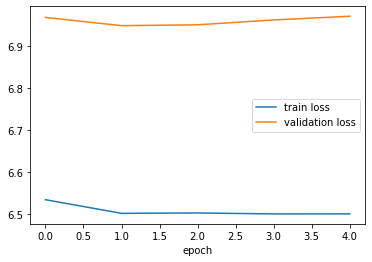

In [74]:
#Full
#save_model = 'save_models/Full/3 datasets/2021May19_20h59'
#Small
#save_model = './save_models/Test_Oversampling/3 datasets/2021May20_16h42'
losses = pd.read_pickle(save_model + "/losses.pkl")

directory = 'save_data/3_datasets_Test_AdaptPartitions/'
Path(directory).mkdir(parents=True, exist_ok=True)
losses.to_pickle(str(directory) + "losses.pkl")
losses_min = losses.loc[losses['validation loss'] == losses['validation loss'].min()]
print('best model found at epoch : ',losses_min['epoch'].item(), 
      ', with train loss : ', losses_min['train loss'].item(),
      ', and validation loss : ', losses_min['validation loss'].item())

plt.figure()
losses.plot(x = 'epoch', y =['train loss','validation loss'],mark_right=False)
plt.savefig(directory + 'loss.png')

np.save('/scratch/celleaume/github/contrastive_learning/images/x_subset.npy',x_subset)

In [ ]:
epoch_best_model = losses.loc[losses['validation loss'] == losses['validation loss'].min()]['epoch'].item()
epoch_best_model = 30
print('using epoch : ', epoch_best_model)

data_set = [ 'train', 'validation','test']
for data in data_set :
    
    best_model = {"encoder_pretrain": lambda: EncoderPretrainNet(config_encoder),
        "decoder_pretrain": lambda: DecoderPretrainNet(config_encoder),
        "seg_unet": lambda: UNet(config_enoder),}[config_encoder['model']]()
    name = str(save_model)+ '/checkpoints_' + str(epoch_best_model) + '.pt'
    checkpoint = torch.load(name, map_location=torch.device('cpu') )
    best_model.load_state_dict(checkpoint['model_state_dict'])
    #best_model = model
    best_model.eval()

    predictions = pd.DataFrame(columns = ['type', 'prediction'])
    seed = 24
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    with torch.no_grad():
        #print("Doing Test...")
        count = 0
        batch_test_loss = []
        
        if data == 'train' : dataset_loader = dataset_loader_train
        if data == 'validation' : dataset_loader = dataset_loader_validation
        if data == 'test' : dataset_loader = dataset_loader_test
        
        print('Doing plots and predictions for: ', data)
        idx = 0
        for batch_x in tqdm(dataset_loader):

            resize_size = next(item for item in config_datasets if item["Data"] == 'ACDC')['resize_size']
            n_channels = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_channels']
            #n_parts = next(item for item in config_datasets if item["Data"] == 'ACDC')['n_parts']
        
            if data == 'test':
                batch_test = batch_x.float().to(device)
                batch_test = batch_test.view((-1, n_channels, *resize_size))
                #batch_test = torch.cat([batch_test, trans(batch_test, 'validation')])
                for batch in batch_test :
                    p = best_model(batch.unsqueeze(0))
                    p = p.squeeze()  
                    if idx < len(volumes_test_heart) :
                        dataset = 'Heart'
                    if idx >= len(volumes_test_heart) and idx < (len(volumes_test_heart) + len(volumes_test_prostate))  :
                        dataset = 'Prostate'
                    if idx > (len(volumes_test_heart) + len(volumes_test_prostate))  :
                        dataset = 'Brain'
                
                    predictions = predictions.append([{'type': dataset, 'prediction' : p.numpy().tolist()}])
                idx += 1
            else:
                batch_test = batch_x.float().to(device)
                batch_test = batch_test.view((-1, n_channels, *resize_size))
                batch_test = torch.cat([batch_test, trans(batch_test, 'validation')])
                for idx, batch in enumerate(batch_test) :
                    p = best_model(batch.unsqueeze(0))
                    p = p.squeeze()  
                    # Before the mid size images are the originals
                    if idx < batch_test.shape[0]/2 :
                        trans_set =  'original '
                    # Then the transforms of each image
                    else:
                        trans_set = 'transformed '
                    # Indexing of the datasets depending on the partition
                    n = 0
                    for i, n_parts in enumerate(n_partitions) :
                        if (idx % total_n_parts) < n_parts + n :
                            dataset = datasets[i]
                        n += n_parts
                    print(n)
        

                    predictions = predictions.append([{'type': dataset, 'prediction' : p.numpy().tolist()}])

            
    directory_pred = directory + 'epoch_'+str(epoch_best_model) + '/'+ data
    Path(directory_pred).mkdir(parents=True, exist_ok=True)
    predictions.to_pickle(directory_pred + '/predictions.pkl')
    pca_plot = plotPCA(predictions, norm = True)
    pca_plot.write_image(directory_pred + "/PCA.png")
    tsne_plot = plotTSNE(predictions, norm = False, num_datasets=3, perplexity=8)
    tsne_plot.write_image(directory_pred + "/tSNE.png")


In [ ]:
print(save_model)

In [ ]:
len(predictions)


In [ ]:
predictions

In [ ]:
len(volumes_test_heart)

In [ ]:
len(volumes_test_brain)

In [ ]:
len(volumes_test_prostate)

In [17]:
34%18

16

In [64]:
n_partitions

[3, 5, 10]

In [84]:
datasets

['ACDC', 'Medical Decathelon Prostate', 'Medical Decathelon Brain 1']